In [64]:
# libraries
import os
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import numpy as np

### 1) Which AC was used the most/least?
#### Approach: Minutes of use of different ACs were calculated
#### Finding: AC 1  was used for minimum time i.e  73845  minutes
#### AC 17  was used for maximum time i.e  86861  minutes

In [66]:
#minimum and maximum power use estimation
df1 = pd.read_csv('AC_Data.csv')
min = float("inf");
max = 0;
colname = 'AC 1'
query = ''
minUsedACName = ''
maxUsedACNAme = ''
for i in range(1,19):
    l = list(colname)
    while(len(l) != 3):
        l.pop()
    l1 = list(str(i))
    for x in l1:
        l.append(x)
    query = ''.join(l)
    #print(df1.loc[df1[query] == 0,[query]].count().values[0])
    if df1.loc[df1[query] == 0,[query]].count().values[0] > max:
        max = df1.loc[df1[query] == 0,[query]].count().values[0]
        minUsedACName = query
    if df1.loc[df1[query] == 0,[query]].count().values[0] < min:
        min = df1.loc[df1[query] == 0,[query]].count().values[0]
        maxUsedACNAme = query
print(minUsedACName, ' was used for minimum time i.e ', df1.shape[0] - max, ' minutes')
print(maxUsedACNAme, ' was used for maximum time i.e ', df1.shape[0] - min, ' minutes') 

AC 1  was used for minimum time i.e  73845  minutes
AC 17  was used for maximum time i.e  86861  minutes


### 2) Can we relate this power data with the outside temperature of Gurgaon?

#### Approach:  Data was fetched from Nasa website, ideally it should be fetched using API call (mostly paid)
#### Data on daily basis
#### Ref Link: https://power.larc.nasa.gov/data-access-viewer/ PFA attached data in file for reference
#### Findings: correlation matrix

In [67]:
df1.rename(columns ={'0': 'Datetime'}, inplace = True)
df1['Datetime'] = pd.to_datetime(df1['Datetime'], format="%Y-%m-%d %H:%M:%S")
df = df1.groupby(pd.Grouper(key='Datetime',freq='60T')).sum()
df['average_power'] = df.mean(axis =1)
df.drop(df.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]], axis =1, inplace = True)

correlationCheck = df1.groupby(pd.Grouper(key='Datetime',freq='1D')).sum()
nasaData = pd.read_csv('POWER_SinglePoint_Daily_20190801_20190930_028d48N_077d30E_717875d6.csv')
correlationCheck['average_power'] = df.mean(axis =1)
correlationCheck['temp'] = np.array(nasaData['T2M'])
correlationCheck.drop(correlationCheck.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]], axis =1, inplace = True)
correlationCheck.corr()

,average_power,temp
average_power,1.000000,0.354579
temp,0.354579,1.000000


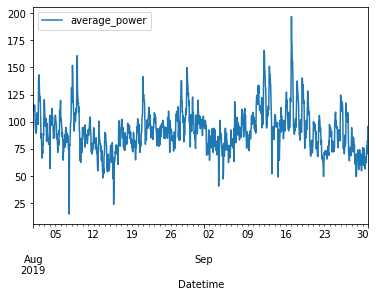

In [68]:
df.index.freq = 'H'
df.plot()
plt.show()

### 3) Are there any patterns/trends in the data?
#### Approach: Data decompose was done to chech trend, seasonality and noise
#### Findings: No overall increasing or decreasing trend but seasonality is there

No overall increasing or decreasing trend but seasonality is there


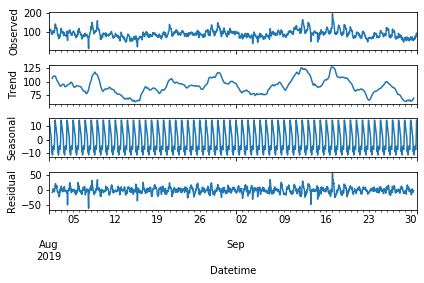

In [69]:
# trend capure
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df,model='additive')
decompose_result.plot();

print('No overall increasing or decreasing trend but seasonality is there')

### 4) Using the power data, can we predict/forecast the power consumption?
#### Approach: Holt winter forecasting was used (Hourly data used with a sequence of 24 hours)
####                    SSE, AIC and BIC was evaluated based on following model:
####                    trend = "additive" , seasonal='additive'
####                    trend = "additive" , seasonal='multiplicative'
####                    trend = "none" , seasonal='additive'
####                    trend = "none" , seasonal='multiplicative'
#### Findings: trend = "none" , seasonal='multiplicative' can be used for forecasting 

In [70]:
df_train = df.iloc[:-24]
df_test = df.iloc[-24:]
model = HWES(df_train, seasonal_periods=24, seasonal='mul')
fitted = model.fit()
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1440
Model:             ExponentialSmoothing   SSE                          81090.258
Optimized:                         True   AIC                           5856.524
Trend:                             None   BIC                           5993.607
Seasonal:                Multiplicative   AICC                          5857.675
Seasonal Periods:                    24   Date:                 Mon, 03 May 2021
Box-Cox:                          False   Time:                         11:51:42
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7476718                alpha                 True
smoothing_seasonal       

#### Forecasting

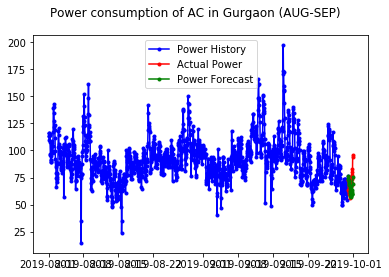

In [71]:
power_forecast = fitted.forecast(steps=24)
fig = plt.figure()
fig.suptitle('Power consumption of AC in Gurgaon (AUG-SEP)')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Power History')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Power')
predicted_future, = plt.plot(df_test.index, power_forecast, 'g.-', label='Power Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

### Zoom through prediction

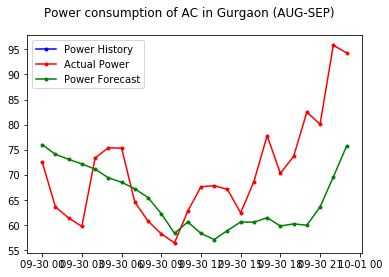

In [72]:
fig = plt.figure()
fig.suptitle('Power consumption of AC in Gurgaon (AUG-SEP)')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Power')
predicted_future, = plt.plot(df_test.index, power_forecast, 'g.-', label='Power Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()